In [1]:
from Games.CoopEnv_on import CoopEnv
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [2]:
n = 5
tasks = 3
env = CoopEnv(n=n, task_num=tasks)
action_size = env.num_of_tasks

In [3]:
class ActorNetwork(tf.keras.Model):
    
    def __init__(self):
        
        super().__init__()
        # Shared layers for policy and value function networks
        self.layer1 = tf.keras.layers.Dense(256, activation = 'relu')
        self.layer2 = tf.keras.layers.Dense(256, activation = 'relu')
        self.pout = tf.keras.layers.Dense(action_size, activation = 'softmax') # state to action probabilities 
        
    def call(self, state):
        
        x = tf.convert_to_tensor(state)
        x = self.layer1(x)
        x = self.layer2(x)
        probs = self.pout(x)
        
        return probs

In [4]:
class CriticNetwork(tf.keras.Model):
    
    def __init__(self):
        
        super().__init__()
        # Shared layers for policy and value function networks
        self.layer1 = tf.keras.layers.Dense(256, activation = 'relu')
        self.layer2 = tf.keras.layers.Dense(256, activation = 'relu')
        self.vout = tf.keras.layers.Dense(1, activation = None) # ... from state to value scalar
        
    def call(self, state):
        
        x = tf.convert_to_tensor(state)
        x = self.layer1(x)
        x = self.layer2(x)
        value = self.vout(x)
        
        return value


In [5]:
class Agent():
    
    def __init__(self):
        self.aModel = ActorNetwork()
        self.vModel = CriticNetwork()
        self.gamma = 0.99
        self.alr = 1e-4
        self.clr = 1e-4
        self.aopt = tf.keras.optimizers.Adam(learning_rate=self.alr)
        self.copt = tf.keras.optimizers.Adam(learning_rate=self.clr)
        
    def choose_action(self, state):
        a_probs = self.aModel(np.array([state]))
        dist = tfp.distributions.Categorical(probs = a_probs, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
    
    def calculate_loss(self, a_probs, action, delta):
        dist = tfp.distributions.Categorical(probs = a_probs, dtype=tf.float32)
        log_prob = dist.log_prob(action) # get log(pi(a\s))
        return -log_prob*delta
    
    def train(self, state, action, reward, next_state, terminated): # train from an episode of experience
        
        state = np.array([state])
        next_state = np.array([next_state])
        
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
            a =  self.aModel(state,training=True) # action probabilities and value of state S_t
            v = self.vModel(state, training=True) # action probabilities and value of state S_t+1
            v_p = self.vModel(next_state, training=True)
            td = reward + self.gamma*v_p - v # calculate TD error
            
            a_update = self.calculate_loss(a, action, td)
            c_update = td**2
        
        grads1 = tape1.gradient(a_update, self.aModel.trainable_variables)
        grads2 = tape2.gradient(c_update, self.vModel.trainable_variables)
        self.aopt.apply_gradients(zip(grads1, self.aModel.trainable_variables))
        self.copt.apply_gradients(zip(grads2, self.vModel.trainable_variables))
        
        return a_update, c_update


In [6]:
num_of_sims = 1
step_limit = 5000
steps_to_complete = np.zeros((num_of_sims, step_limit+1))

In [7]:
def main():
    
    for s in range(num_of_sims):
        
        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")
        
        # reinitialise agent list each sim
        agentlist = {}
        for agent in range(env.n):
            agentlist[agent] = Agent() # instantiate an Agent() class for each player
         
        t = 0
        observations = env.reset(n=n, task_num=tasks)

        print(observations)
        
        while t < step_limit:
            print(t)

            actions = [agentlist[agent].choose_action(observations[agent]) for agent in range(env.n)]

            next_observations, rewards, termination, info = env.step(actions)

            for i in agentlist:
                agent = agentlist[i]
                agent.train(observations[i], actions[i], rewards[i], next_observations[i], termination)

            observations = next_observations
            steps_to_complete[s, t+1] = sum(rewards) + steps_to_complete[s, t]
            t +=1

            


In [8]:
if __name__ == "__main__":
    
    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------
[array([1., 1., 0., 0., 0.]), array([1., 1., 0., 0., 0.]), array([0., 0., 1., 0., 1.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 1.])]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
21

[0.00000000e+00 3.43540819e+00 7.13062890e+00 ... 3.29185260e+04
 3.29259195e+04 3.29333131e+04]


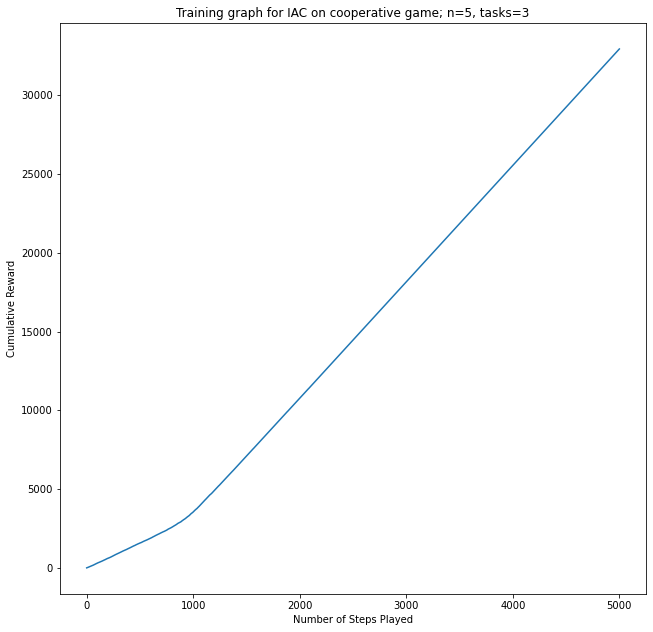

In [11]:
b = np.mean(steps_to_complete, axis=0)
print(sum(steps_to_complete))
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Reward')
plt.title(f'Training graph for IAC on cooperative game; n={n}, tasks={tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)